In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set

Dataset URL: https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set
License(s): DbCL-1.0
electric-power-consumption-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref =  zipfile.ZipFile(r'/content/electric-power-consumption-data-set.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
!pip uninstall -y scikit-learn
!pip install scikit-learn==1.5.2

Found existing installation: scikit-learn 1.5.2
Uninstalling scikit-learn-1.5.2:
  Successfully uninstalled scikit-learn-1.5.2
  Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.3 MB)


### Introduction:
Household energy consumption has become a significant area of research as the world moves towards optimizing energy usage and integrating renewable energy sources. In this project, we analyze the Household Electric Power Consumption dataset, which contains measurements of electric power consumption for a single household over nearly four years. The goal is to forecast Global Active Power—a key metric representing the active power consumed by the household—using time-series modeling techniques.

Given the temporal nature of the data, a Long Short-Term Memory (LSTM) neural network, a type of recurrent neural network (RNN) suited for sequential data, was employed. The LSTM model can capture both short-term and long-term dependencies in the data, making it an ideal choice for time-series forecasting. Key preprocessing steps included creating lag-based input sequences and scaling the features to improve model convergence.

To evaluate the performance of the model, metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), and Mean Absolute Percentage Error (MAPE) were calculated on a test dataset. These metrics provide insights into the model's predictive accuracy and its ability to generalize.



### Import Libraries:

In [ ]:
# Basic Libraries
import numpy as np
import pandas as pd

# Data Visualizaion libraries
import matplotlib.pyplot as plt
import seaborn as sns

# ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# DL Libraries
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping

# Warning text elimination
import warnings
warnings.filterwarnings('ignore')

### Helping Functions:

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support,roc_curve, auc, accuracy_score

# Model Evaluation
def model_evaluation(yt, yp):
    results = {}
    results['accuracy'] = accuracy_score(yt, yp)

    precision, recall, fscore, _ = precision_recall_fscore_support(yt, yp, average = 'weighted')
    results['precision'] = precision
    results['recall'] = recall
    results['fscore'] = fscore

    metrics = list(results.keys())
    values = list(results.values())

    ax = sns.barplot(x = metrics, y = values, palette = 'viridis')
    plt.title('Model Evaluation Metrics')
    plt.ylim(0,1)
    plt.ylabel('Value')

    for i, v in enumerate(values):
        plt.text(i, v/2, f'{v: 0.2f}', ha = 'center', va = 'center', color = 'white',
                fontsize = 12)
    plt.show()

# Classification Report
def class_report(yt, yp):
    cr = pd.DataFrame(classification_report(yt, yp, output_dict = True))
    return cr.T.style.background_gradient(cmap = 'Blues', axis = 0)

# Confusion Matrix
def conf_matrix(yt, yp):
    cm = confusion_matrix(yt, yp)
    sns.heatmap(cm, annot = True, linecolor = 'black', fmt = '0.2f', cmap = 'Blues',
               linewidths = 0.01)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

def plot_roc(yt, yp):
    fpr, tpr, thr = roc_curve(yt, yp)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize = (6,6))
    plt.plot(fpr, tpr, color = 'darkorange', lw=2,
            label = f"ROC_CURVE (Area = {roc_auc : 0.3f})")
    plt.plot([0.0, 1.0], [0.0, 1.0], lw=2, color = 'navy', linestyle = '--')
    plt.xlim([-0.01, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()

### Exploratory Data Analysis:

In [ ]:
df = pd.read_csv(r'/content/household_power_consumption.txt', sep = ';')
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
# Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075259 entries, 0 to 2075258
Data columns (total 9 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Date                   object 
 1   Time                   object 
 2   Global_active_power    object 
 3   Global_reactive_power  object 
 4   Voltage                object 
 5   Global_intensity       object 
 6   Sub_metering_1         object 
 7   Sub_metering_2         object 
 8   Sub_metering_3         float64
dtypes: float64(1), object(8)
memory usage: 142.5+ MB


Dataset contaisns the string values. So we will have convert it to the numeric values and then remove all those string values that could not convert to numeric and became the missing values.

In [ ]:
# Merging time and date to datetime
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format = '%d/%m/%Y %H:%M:%S')

# Set Datetime as index
df.set_index('datetime', inplace = True)

# Dataset view
df.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,,,
2006-12-16 17:24:00,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [ ]:
# Dropping the Date and time columns
df.drop(columns = ['Date', 'Time'], inplace = True)

df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

In [ ]:
# Converting the non-numeric features to the numeric
for col in df.columns:
  df[col] = pd.to_numeric(df[col], errors = 'coerce')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
# Finding the null values
print(f'Null values:\n')
print(df.isnull().sum())

# Finding the missing values
print(f'Missing values:\n')
print(df.isna().sum())

Null values:

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64
Missing values:

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


Dataset contains missing and null values. So our next sep should be to remove null or missing values. However, our dataset is time series so the continuity and relation of previous and after values is importan. So if this consistency is lost then it would affect our prediction.
Therefore, in order to solve such problems we will use ffill and bffill (forward and backword fill) methods to fill the missing values so that consistency would not be last.

In [ ]:
# Filling missing and null values
df = df.ffill().bfill()

# Finding the null values
print(f'Null values:\n')
print(df.isnull().sum())

# Finding the missing values
print(f'Missing values:\n')
print(df.isna().sum())

Null values:

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64
Missing values:

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


In [ ]:
# Discriptive Statistics
def discriptive_stat(data):
  summary = data.describe().T
  summary['skew'] = data.skew()
  summary['kurtosis'] = data.kurtosis()
  return summary

discriptive_stat(df)

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
Global_active_power,2075259.0,1.086168,1.053172,0.076,0.308,0.598,1.524,11.122,1.797454,4.281408
Global_reactive_power,2075259.0,0.123328,0.112514,0.000,0.048,0.100,0.194,1.390,1.265232,2.626383
Voltage,2075259.0,240.841608,3.235574,223.200,239.000,241.020,242.870,254.150,-0.323726,0.718285
Global_intensity,2075259.0,4.604226,4.426775,0.200,1.400,2.600,6.400,48.400,1.860937,4.669535
Sub_metering_1,2075259.0,1.110995,6.115908,0.000,0.000,0.000,0.000,88.000,5.983578,36.140909
Sub_metering_2,2075259.0,1.287958,5.786865,0.000,0.000,0.000,1.000,80.000,7.135711,58.672685
Sub_metering_3,2075259.0,6.416570,8.419505,0.000,0.000,1.000,17.000,31.000,0.736887,-1.264991


**Discriptive Statistics:**

- Global_active_power: It shows that average usage of the energy is 1.086 but std is 1.05 this shows that mostly the cunsumption of the wnergy is less. However, it is left skewed (skewness < 0) and there are more outliers (kurtosis > 3).
- Global_reactive_power: mean is 0.123 and std is 0.112. It also shows that reactive power consumption is less than in general case because it is less than its mean. Whereas, it is left skewed and outliers are less than it was in the Global_active_power (kurtosis < 3).
- Voltage: mean is 240.84 and std is 3.23. So it means that voltage supply is more than its mean. Wherasas it is right skewed (skewness < 0) and (kurtosis < 3). so voltage is skewed and also there are outliers.
- sub_metering(1 2 3): means and stds show that the consumption of energy in house appliances and rooms is showed to be more than its mean or less than mean.



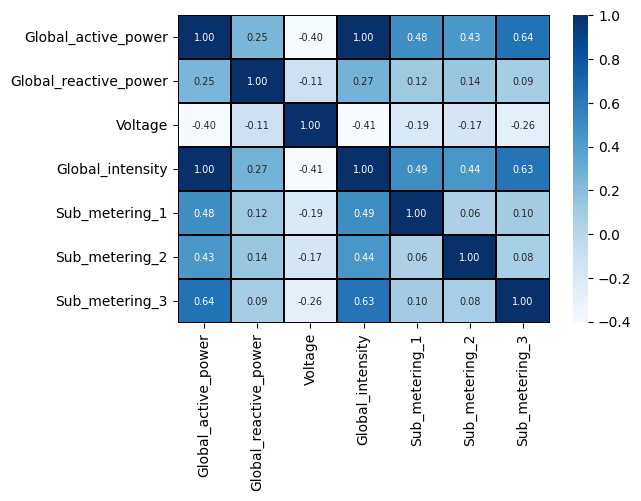

In [ ]:
# Correlation Matrix:
plt.figure(figsize = (6,4))
corr = df.corr()
sns.heatmap(corr, annot = True, cmap = 'Blues', linewidths = 0.01, linecolor = 'black',
           fmt = '0.2f', annot_kws = {'fontsize' : 7})
plt.xticks(fontsize = 10, rotation = 90)
plt.yticks(fontsize = 10, rotation = 0)
plt.show()

- Global_active_power has stong positive relation with the Global_intensity.
- Global_active_power has also positive relation with sub_metering_3.

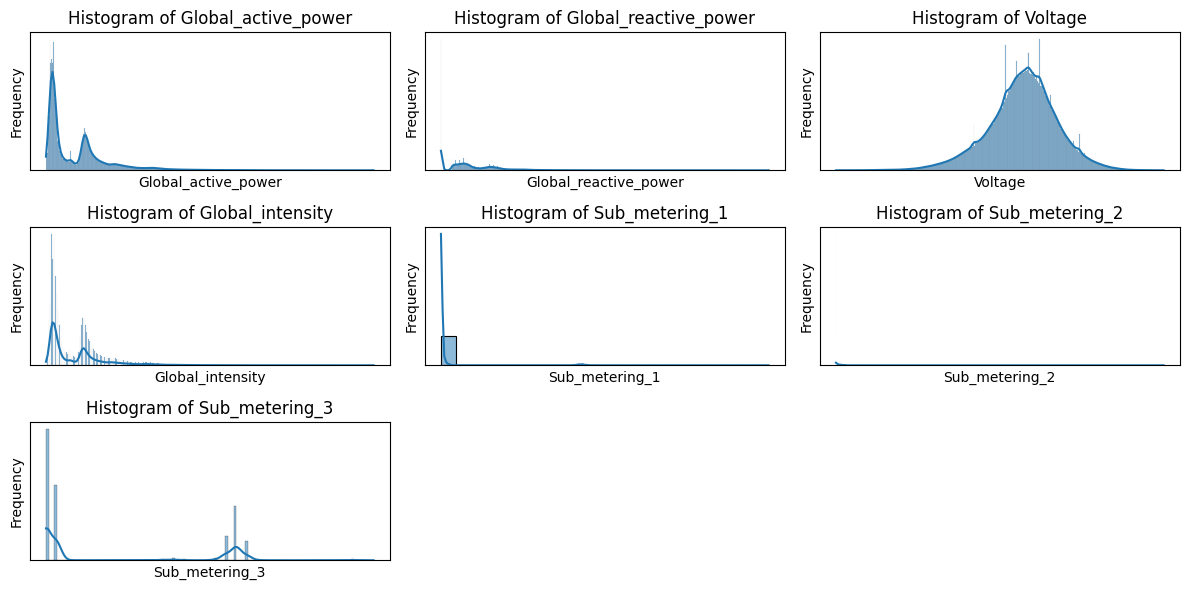

In [ ]:
n = len(df.columns)
nrow = int(np.ceil(n / 3))

fig, axes = plt.subplots(nrow, 3, figsize = (12,6))

for i, col in enumerate(df.columns):
    ax = axes.flat[i]
    sns.histplot(df[col], kde = True, ax=ax)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.set_xticks([])
    ax.set_yticks([])

for ax in axes.flat[n:]:
    ax.axis('off')

fig.tight_layout()
plt.show()

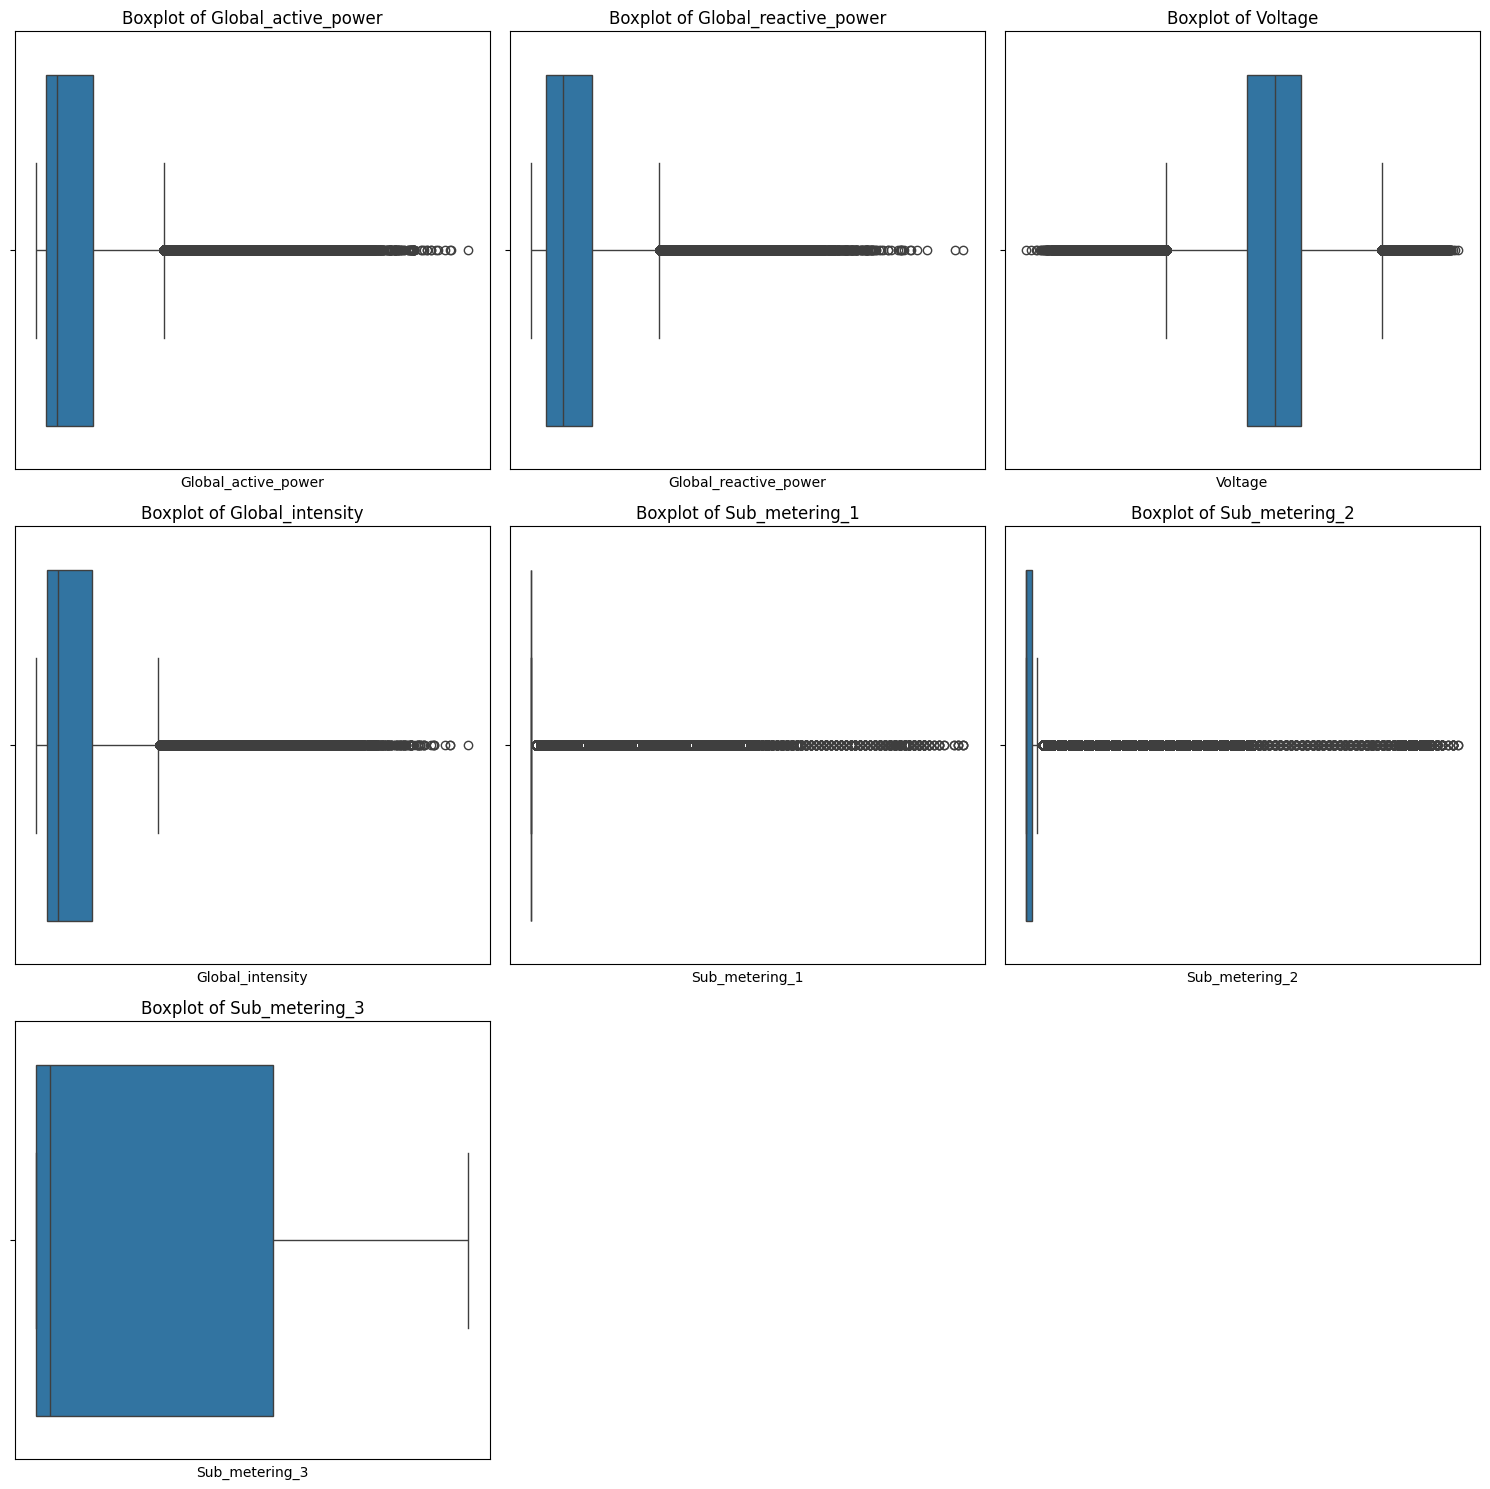

In [ ]:
n = len(df.columns)
nrow = int(np.ceil(n / 3))

fig, axes = plt.subplots(nrow, 3, figsize = (15, 5 * nrow))

axes = axes.flatten()

for i, col in enumerate(df.columns):
    sns.boxplot(x = df[col], ax = axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_xticks([])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

The figures of histogram and boxplot describe the data as we have described before that there are outliers because of kurtosis' values are away from 3 which denotes that outliers exist.
Hence, we will normalize the data so that whole distribution will be in mean = 0 and std = 1. So in other words we will transform data into normal distribution.

### Data Preprocessing:

In [ ]:
# Data Normalization
std_scaler = StandardScaler()
df_scaled = std_scaler.fit_transform(df)

In [ ]:
# # Create dataset for the LSTM model
# def create_lstm_dataset(data, time_steps = 4):
#   X, y = [], []

#   for i in range(len(data) - time_steps):
#     X.append(data[i : i + time_steps])
#     y.append(data[i + time_steps])

#   return np.array(X), np.array(y)

# X, y = create_lstm_dataset(df_scaled, 4)

def create_lstm_dataset(data, target_index, time_steps=4):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i + time_steps, :])  # Use all features for X
        y.append(data[i + time_steps, target_index])  # Use only the target feature for y

    # Exclude the target column from X
    X = np.array(X)
    X = np.delete(X, target_index, axis=2)  # Remove target column from X
    return X, np.array(y)

# Assuming "Global_active_power" is the target
target_index = df.columns.get_loc("Global_active_power")

# Create X and y datasets
X, y = create_lstm_dataset(df_scaled, target_index, time_steps=4)

# Check shapes
print("X shape:", X.shape)  # (samples, time_steps, features_without_target)
print("y shape:", y.shape)  # (samples,)


X shape: (2075255, 4, 6)
y shape: (2075255,)


In [ ]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.0001, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2075047, 4, 6)
(208, 4, 6)
(2075047,)
(208,)


### LSTM Model:

In [ ]:
# Define the early stopping from callbacks
early_stopping = EarlyStopping(
    monitor = 'val_loss',
    patience = 5,
    verbose = 1,
    restore_best_weights = True
)

In [ ]:
# LSTM model architecture
model = models.Sequential()

model.add(layers.LSTM(50, return_sequences = True,
                      input_shape = (X_train.shape[1], 7)))
model.add(layers.LSTM(50))
# model.add(layers.LSTM(500, return_sequences = False))


model.add(layers.Dense(300, activation = 'relu'))
model.add(layers.Dense(1))

model.compile(
    optimizer = 'adam',
    loss = 'mean_squared_error'
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 4, 50)               │          11,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 300)                 │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             301 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,401 (185.16 KB)

 Trainable params: 47,401 (185.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs = 4,
    batch_size = 128,
    validation_split = 0.2,
    callbacks = [early_stopping]
)

Epoch 1/4
12970/12970 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - loss: 0.0537 - val_loss: 0.0514
Epoch 2/4
12970/12970 ━━━━━━━━━━━━━━━━━━━━ 140s 6ms/step - loss: 0.0507 - val_loss: 0.0531
Epoch 3/4
12970/12970 ━━━━━━━━━━━━━━━━━━━━ 138s 6ms/step - loss: 0.0491 - val_loss: 0.0479
Epoch 4/4
12970/12970 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - loss: 0.0481 - val_loss: 0.0474
Restoring model weights from the end of the best epoch: 4.


In [ ]:
y_pred = model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')


Mean Absolute Error (MAE): 0.08869682739403538
Root Mean Squared Error (RMSE): 0.2419461557943522
Mean Absolute Percentage Error (MAPE): 193.05974750796017


MAE and RMSE are relatively low, which is promising for error magnitude. However, the MAPE being 193% is a concern because it indicates large relative errors.
The large value for MAPE is due to the smaller size of the test data because MAPE is sensitive to the outliers and size.

### Conclusion:
The LSTM model trained for forecasting Global Active Power demonstrated moderate accuracy based on the evaluation metrics:

 - Mean Absolute Error (MAE): 0.0887, indicating the average prediction error in absolute terms.
 -Root Mean Squared Error (RMSE): 0.2419, highlighting a slightly higher penalty for larger errors.
 - Mean Absolute Percentage Error (MAPE): 193.06%, suggesting relative errors are significant, especially when actual values are small.

While the model captures general trends in the data, the high MAPE indicates that its relative performance suffers, particularly for small-scale variations. This could be attributed to the inherent variability in household energy consumption, the limitations of the model architecture, or the need for further fine-tuning and feature engineering.

Future work could include experimenting with more advanced architectures, such as hybrid models combining LSTM with attention mechanisms, or enhancing feature engineering with weather data and other contextual information. Additionally, using more robust evaluation strategies, such as time-series cross-validation, could provide deeper insights into the model's generalizability.

This project underscores the potential of LSTM networks for energy forecasting while also highlighting areas for improvement to achieve more accurate and reliable predictions.

